# 자연어 처리

## 공통 코드

In [7]:
import sys

# 사이킷런 ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
import keras

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NLP"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow import keras

# NLP
## 서브 워드 토크 나이저
### SentencePeice

In [2]:
!pip install sentencepiece

  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/a2/f6/587c62fd21fc988555b85351f50bbde43a51524caafd63bc69240ded14fd/sentencepiece-0.2.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   -- ------------------------------------- 61.4/991.5 kB 1.7 MB/s eta 0:00:01
   --------------------------------------  983.0/991.5 kB 12.5 MB/s eta 0:00:01
   --------------------------------------- 991.5/991.5 kB 10.4 MB/s eta 0:00:00


## 구글의 라이브러리를 이용해서 단어 사전 생성

In [9]:
import csv
import sentencepiece as spm
import urllib.request

In [10]:
# 웹의 텍스트 문서를 다운로드 받아서 파일로 저장
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [11]:
naver_df = naver_df.dropna(how = 'any')
naver_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199992 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        199992 non-null  int64 
 1   document  199992 non-null  object
 2   label     199992 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [12]:
# NULL 을 제거한 데이터를 파일에 기록
with open('naver_review.txt', 'w', encoding = 'utf8') as f :
    f.write('\n'.join(naver_df['document']))

In [14]:
# 단어 사전 생성
spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

# naver.model, naver.vocab 이라는 파일이 만들어집니다.

In [16]:
# 단어 사전 읽어오기
vocab_list = pd.read_csv('naver.vocab', sep = '\t', header = None, quoting = csv.QUOTE_NONE)
vocab_list.head()

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1


In [18]:
# 리뷰 토큰화
sp = spm.SentencePieceProcessor()
vocab_file = 'naver.model'
sp.load(vocab_file)

# 문장을 토큰화
# 단어 사전에 없는 것은 분할은 하지만 수치화 할 수 없습니다.
# 공백을 기준으로 분할만 합ㄴ디ㅏ.
print(sp.encode_as_pieces('진짜 최고의 영화임 ㅋㅋㅋ'))
print(sp.encode_as_ids('진짜 최고의 영화임 ㅋㅋㅋ'))

['▁진짜', '▁최고의', '▁영화임', '▁ᄏᄏᄏ']
[54, 204, 1413, 379]


# 생성형 AI 

## Auto Encoder

### 오토 인코더를 이용한 PCA(주성분 분석- 차원 축소의 일종) 수행

In [19]:
# 데이터 생성
np.random.seed(42)

def generate_3d_data(m, w1 = 0.1, w2 = 0.3, noise = 0.1) :
    angles = np.random.rand(m)*3*np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [27]:
# auto encoder 생성
np.random.seed(42)
tf.random.set_seed(42)

# 입력 데이터를 학습할 수 있는 encoder 를 생성
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape = [3])])

#학습된 내용을 출력으로 변경하는 Decoder를 생성
# 디코더는 인코더의 입력 개수와 출력 개수가 동일해야 합니다.
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape = [2])])

# 오토 인코더는 Encoder 와 Decoder 가 합쳐져서 생성
autoencoder = keras.models.Sequential([encoder, decoder])

# PCA 를 수행하고자 할 때는 활성화 함수를 사용하지 않고 비용함수는  MSE
autoencoder.compile(loss = 'mse', optimizer = keras.optimizers.SGD(learning_rate = 1.5))

#훈련
# 비지도 학습이라서 별도의 레이블이 없고 자기 자신을 레이블로 설정
history = autoencoder.fit(X_train, X_train, epochs = 20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1524 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0591  
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0530  
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0635  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1255  
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1885  
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0717 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0273  
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0271
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0281  
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0269  
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0150  
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0101  
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

## Fashion MNIST 데이터를 이용한 적층 오토 인코더

In [28]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [31]:
# 정규화
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255


X_train, X_valid = X_train_full[:-5000], X_train_full[-5000 :]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000 :]

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(55000, 28, 28)
(55000,)
(5000, 28, 28)
(5000,)


In [35]:
np.random

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(30, activation = 'relu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = [30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'), # 이미지가 일차원으로 출력
    keras.layers.Reshape([28, 28]) # 일차원 데이터를 2차원으로 복원
])

In [36]:
#Encoder와 Decoder 결합
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

#컴파일
#손실 함수는 binary_crossentropy - 이진 분류에 이용
#적층 인코더부터는 이진 판별 문제 입니다 - 생성을 하고 난 후 확인을 해서 진짜 가짜를 판별
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5))

#훈련
history = stacked_ae.fit(X_train, X_train, epochs = 20,
                        validation_data = (X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1155 - val_loss: 0.0085
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 12/20
1719/1719 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
그림 저장: reconstruction_plot


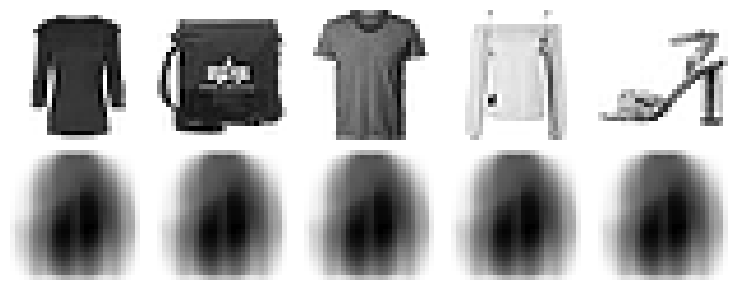

In [37]:
#흑백 이미지를 출력하는 함수
def plot_image(image):
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')
    
#샘플 데이터를 받아서 출력하고, 출력된 데이터를 다시 화면에 그려주는 함수
#모델, 이미지, 개수를 매개변수로 받아서 수행합니다.
def show_reconstructions(model, images = X_valid, n_images = 5):
    #이미지 예측
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    
    for image_index in range(n_images):
        #원본 이미지 출력
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        
        #학습된 이미지 출력
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

### 줄어든 특성을 이용한 시각화

In [38]:
np.random.seed(42)

from sklearn.manifold import TSNE


#차원 축소
#28 * 28 이미지 -> Encoder -> 30차원으로 축소가 됨
X_valid_compressed = stacked_encoder.predict(X_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [39]:
print(X_valid_compressed.shape)

(5000, 30)


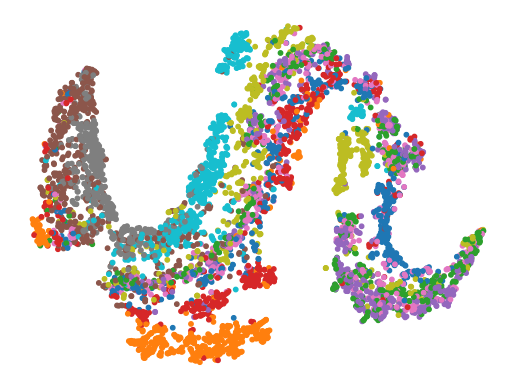

In [40]:
#데이터 셋 시각화
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

그림 저장: fashion_mnist_visualization_plot


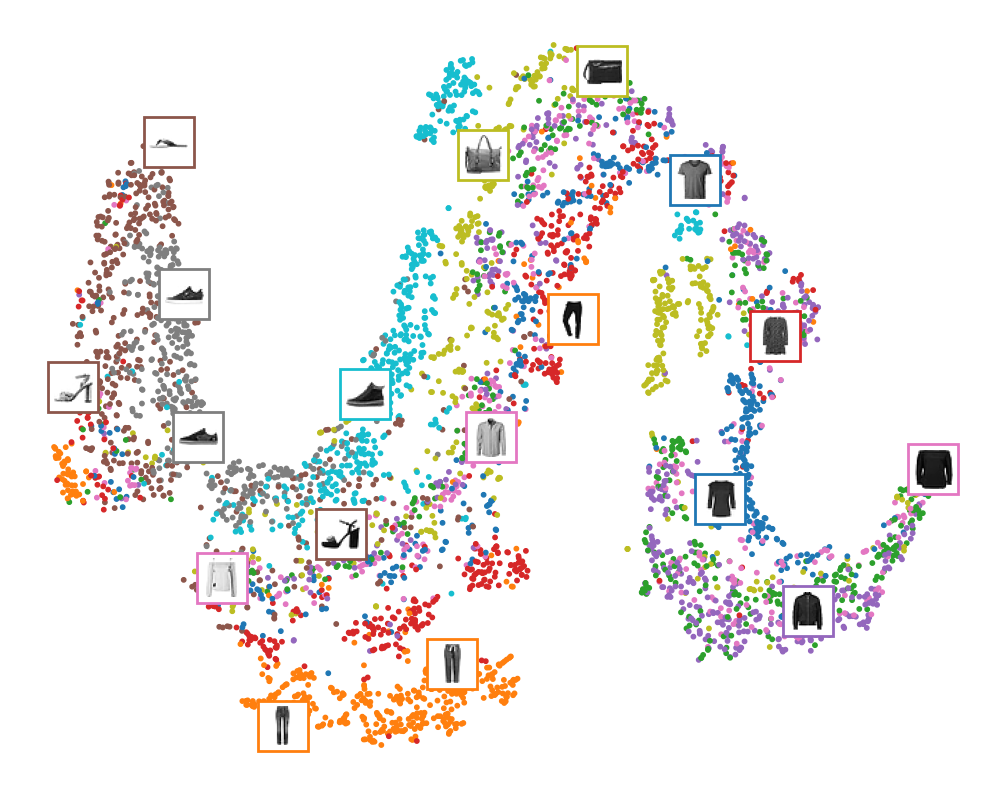

In [41]:
#색상에 원래의 이미지를 출력
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)

#점들 위에 이미지를 출력
image_positions = np.array([[1., 1.]])

for index, position in enumerate(X_valid_2D):
    
    #각 점과 이미지 위치 값을 계산
    dist = np.sum((position - image_positions) ** 2, axis=1)
    
    #출력할 이미지가 다른 이미지와의 거리가 0.02가 넘을 때만 출력
    #이미지 분류를 했을 때 또는 일반 분류 이더라도 이미지가 있는 경우라면
    #이런 형태로 출력해준다면 설명력이 높아집니다.
    #어디서 오류가 많이 발생할지 예측이 가능해집니다.
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        
        #박스 이미지 출력
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## 합성 곱 오토 인코더

In [42]:
#모델 생성
np.random.seed(42)
tf.random.set_seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, 
                                 padding='VALID', activation='selu',input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, 
                                 padding='SAME', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, 
                                 padding='SAME', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

# 인코더의 출력 층 = 디코더의 입력 층
# 인코더의 입력 층 = 디코더의 출력 층

In [47]:
#Encoder와 Decoder 결합
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

#컴파일
#손실 함수는 binary_crossentropy - 이진 분류에 이용
#적층 인코더부터는 이진 판별 문제 입니다 - 생성을 하고 난 후 확인을 해서 진짜 가짜를 판별
conv_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5))

#훈련
history = conv_ae.fit(X_train, X_train, epochs = 20,
                        validation_data = (X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0168 - val_loss: 0.0088
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 12/20
1719/17

# Pytorch

In [43]:
!pip install torch

In [44]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e7/45/419aa0b37254f1fd62b45bb63836066c5eb81e37d70940e0491e95167eed/torchvision-0.17.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torch==2.2.1 from https://files.pythonhosted.org/packages/59/1f/4975d1ab3ed2244053876321ef65bc02935daed67da76c6e7d65900772a3/torch-2.2.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 326.8 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.2 MB 393.8 kB/s eta 0:00:03
   ---- ----------------------------------- 0.1/1.2 MB 554.9 kB/s eta 0:00:02
   ---- ----------------------------------- 0.1/1.2 MB 554.9 k

In [46]:
import torch
print(torch.__version__)

2.2.1+cpu


## MNIST 를 이용해서  MLP(여러개의 layer 로 구성된 네트워크) 구현

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [51]:
# 현재 머신에 nvidia 의 GPU 가 장착된 경우 GPU를 사용하고
# 그렇지 않으면 CPU를 사용
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [56]:
# 데이터 다운로드 - numpy를 이용해서 압축,저장해둔 데이터를 다운로드
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = datasets.MNIST(root = './data/MNIST',
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = './data/MNIST',
                              train = False,
                              transform = transforms.ToTensor())


In [57]:
# 데이터를 메모리에 가져오는 작업
# 데이터를 메모리에 가져오는 작업을 로드한다고 합니다.
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

In [58]:
# 데이터 순회
for (X_train, y_train) in train_loader :
    print(X_train.size())
    break
    

torch.Size([32, 1, 28, 28])


In [59]:
# 모델 설계 - 사용자 정의 클래스를 이용
# python은 다중 상속이 가능한 언어
class Net(nn.Module) :
    def __init__(self) :
        # 첫 번째 상속받은 클래스의 init을 호출
        super(Net, self).__init__()
        # Layer 을 구성
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x) :
        #1차원 펼치기
        x = x.view(-1, 28*28)
        # 입력층 생성
        x = self.fc1(x)
        x = F.sigmoid(x)
        # 히든층 쌓기
        x = self.fc2(x)
        x = F.sigmoid(x)
        # 출력층 만들기
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [60]:
#모델 생성
model = Net().to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

# 모델의 모양 확인
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [66]:
# 훈련하는 사용자 정의 함수 정의
# 훈련 중 원하는 로그를 출력하기 위해서

def train(model, train_loader, optimizer, log_interval) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        #훈련 가능한 데이터로 변경
        image = image.to(DEVICE)
        label = label.to(DEVICE)        
        optimizer.zero_grad()        
        # image를 가지고 출력을 생성
        output = model(image)
        #손실 계산
        loss = criterion(output, label)
        # 역전파
        loss.backward()
        # 다음 스텝으로 진행
        optimizer.step()
        
        if batch_idx % log_interval == 0 :
            print(batch_idx, '번째 배치 진행 중')

In [67]:
def evaluate(model, test_loader) :
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader :
            image, image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [68]:
# 실제 훈련
for epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(epoch, '번째 훈련결과 Test Loss :', test_loss, '정확도 :', test_accuracy)

0 번째 배치 진행 중
200 번째 배치 진행 중
400 번째 배치 진행 중
600 번째 배치 진행 중
800 번째 배치 진행 중
1000 번째 배치 진행 중
1200 번째 배치 진행 중
1400 번째 배치 진행 중
1600 번째 배치 진행 중
1800 번째 배치 진행 중
1 번째 훈련결과 Test Loss : 0.06970132269859314 정확도 : 34.13
0 번째 배치 진행 중
200 번째 배치 진행 중
400 번째 배치 진행 중
600 번째 배치 진행 중
800 번째 배치 진행 중
1000 번째 배치 진행 중
1200 번째 배치 진행 중
1400 번째 배치 진행 중
1600 번째 배치 진행 중
1800 번째 배치 진행 중
2 번째 훈련결과 Test Loss : 0.038538186287879944 정확도 : 62.74
0 번째 배치 진행 중
200 번째 배치 진행 중
400 번째 배치 진행 중
600 번째 배치 진행 중
800 번째 배치 진행 중
1000 번째 배치 진행 중
1200 번째 배치 진행 중
1400 번째 배치 진행 중
1600 번째 배치 진행 중
1800 번째 배치 진행 중
3 번째 훈련결과 Test Loss : 0.023944643139839173 정확도 : 77.05
0 번째 배치 진행 중
200 번째 배치 진행 중
400 번째 배치 진행 중
600 번째 배치 진행 중
800 번째 배치 진행 중
1000 번째 배치 진행 중
1200 번째 배치 진행 중
1400 번째 배치 진행 중
1600 번째 배치 진행 중
1800 번째 배치 진행 중
4 번째 훈련결과 Test Loss : 0.018402116215229036 정확도 : 83.1
0 번째 배치 진행 중
200 번째 배치 진행 중
400 번째 배치 진행 중
600 번째 배치 진행 중
800 번째 배치 진행 중
1000 번째 배치 진행 중
1200 번째 배치 진행 중
1400 번째 배치 진행 중
1600 번째 배치 진행 중
1800 번째 배치 진행 중
5 번째 훈련결과 Test Lo